<table width = "100%">
  <tr style="background-color:white;">
    <!-- QWorld Logo -->
    <td style="text-align:left;width:200px;"> 
        <a href="https://qworld.net/" target="_blank"><img src="../images/QWorld.png"> </a></td>
    <td style="text-align:right;vertical-align:bottom;font-size:16px;"> 
        Prepared by AkashNarayanan B, <a href="https://gitlab.com/pjr1363" target="_blank"> Paul Joseph Robin</a> and Özlem Salehi</td>    
</table>
<hr>

# BQM for the Graph Coloring Problem

Let us briefly recall the graph coloring problem. Given a graph, the question is to decide whether the graph can be colored so that the adjacent vertices have a different color from the set of $K$ colors.

QUBO formulation is given as:

$$  \sum_{i=0}^{N-1} \left(1-\sum_{c=0}^{K-1}x_{i,c}\right)^2 +  \sum_{(i,j) \in E} \sum_{c=0}^{K-1} x_{i,c}x_{j,c}$$


### Imports

In [1]:
from collections import defaultdict

import dimod
from dimod import BQM
import dwave_networkx as dnx
#from neal import SimulatedAnnealingSampler
from dwave.samplers import SimulatedAnnealingSampler
import networkx as nx

from bqm_utils import graph_viz, graph_coloring_viz

## Built-in Function

`vertex_color` is the builtin function in the `dwave-networkx` package for solving the graph coloring problem.

### Parameters

- `G` - The NetworkX graph
- `colors` - List of colors
- `sampler` - BQM sampler for solving the NetworkX graph




### Example 1



Consider this graph with five nodes which was [introduced](QUBO_Examples_GraphColoring_Solutions#task5) in the Graph Coloring notebook. 

<img src="../images/gc_2.png" width="200">


Let us create the above graph using NetworkX and decide whether it is possible to color the graph using with color using the built-in function available in `dwave_networkx` package. We will use the `SimulatedAnealingSampler`.

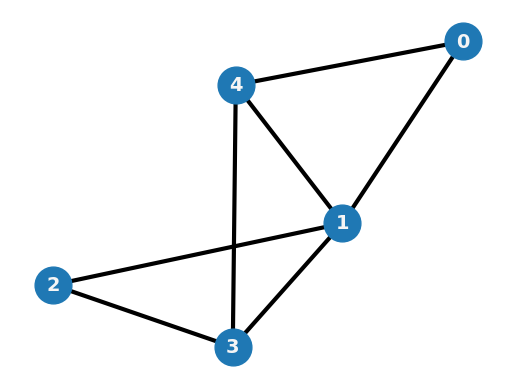

In [2]:
G = nx.Graph()
edges = [(0, 1), (0,4), (1,2), (1,3), (1,4), (2,3), (3,4)]
G.add_edges_from(edges)
graph_viz(G)

Let's define the list of colors.

In [3]:
colors = [0, 1, 2]

In [4]:
sampler = SimulatedAnnealingSampler()
coloring = dnx.vertex_color(G, colors, sampler)
print(coloring)

{0: 0, 1: 1, 2: 2, 3: 0, 4: 2}


Note that it may not be always the case that it is possible to color the graph with the list of provided colors. We can use the following built-in function to verify whether the found coloring is feasible i.e. all adjacent nodes are colored using a different color.

In [5]:
dnx.is_vertex_coloring(G, coloring)

True

Let us visualize the result.

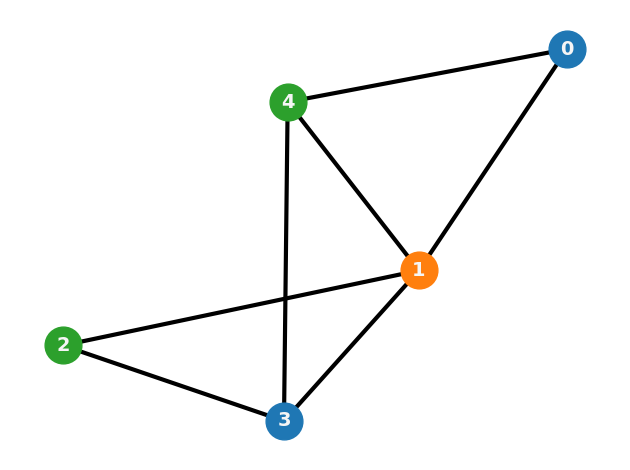

In [6]:
graph_coloring_viz(G, coloring)

## Formulating BQM using OceanSDK functions

### Step 1 - Define an empty BQM

In [7]:
bqm = BQM('BINARY')

### Step 2 -  Add the Constraints to the BQM

Using the functionality of ``BQM` class, we will add the constraints directly instead of using the penalty method.

#### Constraint 1

Each node should be colored exactly once.

$$
\sum_{c=0}^{K-1} x_{i,c} = 1 \quad \forall  i=0,\dots,N-1
$$

### Task 1

Add the first constraint to the BQM.

In [9]:

#Your code here

N = len(G.nodes)
colors = [0,1,2]
for i in range(N):
    c1 = [(f"x_{i}_{c}", 1) for c in colors]
    bqm.add_linear_equality_constraint(c1, constant=-1, lagrange_multiplier=1)

[click here for solution](BQM_Graph_Coloring_Solutions.ipynb#Task1)

#### Constraint 2

Adjacent nodes should have different colors.

$$
x_{i,c} + x_{j,c} \leq 1 \quad \forall  c=1,\dots,K \text{ and } (i,j) \in E
$$

We use the function `add_linear_inequality_constraint` through which you can add linear inequality constraints of the form 

$$lb \leq c_1x_1+c_2x_2+\dots+c_nx_n+c \leq ub.$$

The coefficients for the binary variables should be provided as a list

$$[(x_1,c_1), (x_2,c_2), \dots, (x_n,c_n)] $$

followed by the constant term $c$ and the `lagrange_multiplier` parameter which corresponds to the penalty coefficient we have seen. 

`lb` and `ub`are the lower and upper bounds which are by default set to 0. They are optional parameters.

Additionaly, `label` is a must have parameter by which you should put a label for the inequality constraint.


In [10]:
for c in colors:
    for i, j in G.edges:
        c2 = [(f"x_{i}_{c}", 1), (f"x_{j}_{c}", 1)]
        bqm.add_linear_inequality_constraint(
            c2, lagrange_multiplier=1, ub=1, label=f"c2_{i}_{j}_{c}"
        )

You will see that in the sampleset, there will be additional <b>slack</b> variables named using the label of the inequality constraint. 

Those are created when converting inequality to equality. 

### Step 3 - Solve the BQM

In [11]:
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=100)
print(sampleset.truncate(10))

  slack_c2_0_1_0_0 slack_c2_0_1_1_0 slack_c2_0_1_2_0 ... x_4_2 energy num_oc.
0                0                0                1 ...     1    0.0       1
1                0                1                0 ...     0    0.0       1
2                0                0                1 ...     1    0.0       1
3                0                1                0 ...     0    0.0       1
4                0                0                1 ...     1    0.0       1
5                0                0                1 ...     1    0.0       1
6                1                0                0 ...     0    0.0       1
7                0                1                0 ...     0    0.0       1
8                0                1                0 ...     0    0.0       1
9                1                0                0 ...     0    0.0       1
['BINARY', 10 rows, 10 samples, 36 variables]


### Step 4 - Interpret and check the feasibility of the samples in the sampleset and find the optimum sample

As a result of simulated annealing, we obtain a sample where some of the variables are set to 1 and some of the variables are set to 0. 



Given a sample, we may want to check if it corresponds to a feasible solution or not, i.e. whether each node is colored so that the adjacent nodes are colored using different colors.

### Task 2

Write a Python function named `is_sample_feasible` that takes as parameter a sample containing binary variables named `x_i_c` and their values, the list of colors, the list of edges, and the number of nodes and returns True if the sample corresponds to a feasible coloring and false otherwise.

In [12]:
def is_sample_feasible(sample, colors, edges, N):
    
    # Your code here
    for i, j in edges:
        for c in colors:
            if sample[f"x_{i}_{c}"] == 1 and sample[f"x_{j}_{c}"] == 1:
                return False        
    for i in range(N):
        if sum(sample[f"x_{i}_{c}"] for c in colors) != 1:
            return False
    return True

In [13]:
first_sample = sampleset.first.sample
is_sample_feasible(first_sample, colors, G.edges, N)

True

[click here for solution](BQM_Graph_Coloring_Solutions.ipynb#Task1)

In case the first sample is not feasible, we may search for another solution among the sampleset which is feasible. This can be accomplished by the following code:

In [14]:
def best_solution(sampleset, colors, edges, N):
    for sample, energy in sampleset.data(fields=["sample", "energy"]):
        if is_sample_feasible(sample, colors, edges, N):
            return sample, energy
    return None, None

In [15]:
sample, energy = best_solution(sampleset, colors, G.edges, N)
print(sample)

{'slack_c2_0_1_0_0': 0, 'slack_c2_0_1_1_0': 0, 'slack_c2_0_1_2_0': 1, 'slack_c2_0_4_0_0': 1, 'slack_c2_0_4_1_0': 0, 'slack_c2_0_4_2_0': 0, 'slack_c2_1_2_0_0': 0, 'slack_c2_1_2_1_0': 1, 'slack_c2_1_2_2_0': 0, 'slack_c2_1_3_0_0': 0, 'slack_c2_1_3_1_0': 0, 'slack_c2_1_3_2_0': 1, 'slack_c2_1_4_0_0': 0, 'slack_c2_1_4_1_0': 1, 'slack_c2_1_4_2_0': 0, 'slack_c2_2_3_0_0': 1, 'slack_c2_2_3_1_0': 0, 'slack_c2_2_3_2_0': 0, 'slack_c2_4_3_0_0': 1, 'slack_c2_4_3_1_0': 0, 'slack_c2_4_3_2_0': 0, 'x_0_0': 0, 'x_0_1': 1, 'x_0_2': 0, 'x_1_0': 1, 'x_1_1': 0, 'x_1_2': 0, 'x_2_0': 0, 'x_2_1': 0, 'x_2_2': 1, 'x_3_0': 0, 'x_3_1': 1, 'x_3_2': 0, 'x_4_0': 0, 'x_4_1': 0, 'x_4_2': 1}


---

Suppose we verified that the sample is feasible. Then we would like to obtain the coloring it corresponds to.

In the next Task, your goal is to convert a given sample into a coloring in the form of a dictionary where the keys are the nodes and values are the colors. 

### Task 3

Write a function named `sample_to_coloring` that takes as parameter a sample containing binary variables named `x_i_c` and their values, the list of colors and the number of vertices, and returns a dictionary where the keys are the nodes and the values are the colors.

In [16]:
def sample_to_coloring(sample, colors, N):
    
    # Your code here
    coloring = {}
    for i in range(N):
        for c in colors:
            if sample[f"x_{i}_{c}"] == 1:
                coloring[i] = c
    return coloring

In [17]:
coloring = sample_to_coloring(sample, colors, N)
print(coloring)

{0: 1, 1: 0, 2: 2, 3: 1, 4: 2}


[click here for solution](BQM_Graph_Coloring_Solutions.ipynb#Task3)

Note that once you obtain this dictionary, you can also use the built-in function to check feasibility.

In [18]:
dnx.is_vertex_coloring(G, coloring)

True

### Step 5 - Visualize the Output

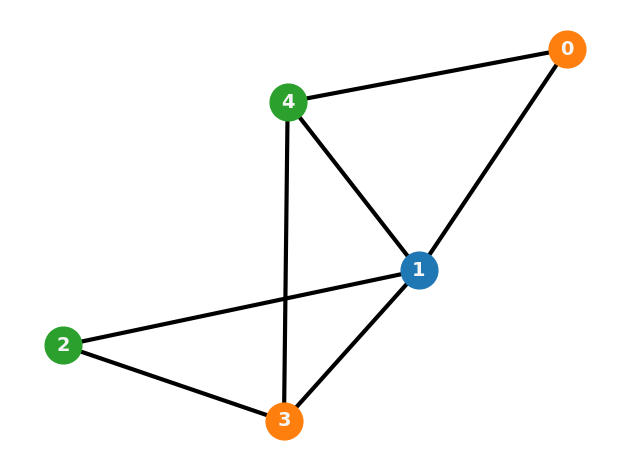

In [19]:
graph_coloring_viz(G, coloring)

### Task 4

Create a function named `graph_coloring_bqm` that takes as input the list of colors, the list of edges, number of vertices and returns the binary quadratic model for the graph coloring problem. 


In [20]:
def graph_coloring_bqm(colors, edges, N):
    # Your code here
    bqm = BQM("BINARY")
    for i in range(N):
        c1 = [(f"x_{i}_{c}", 1) for c in colors]
        bqm.add_linear_equality_constraint(c1, constant=-1, lagrange_multiplier=1)
    for c in colors:
        for i, j in edges:
            c2 = [(f"x_{i}_{c}", 1), (f"x_{j}_{c}", 1)]
            bqm.add_linear_inequality_constraint(
                c2, lagrange_multiplier=1, ub=1, label=f"c2_{i}_{j}_{c}"
            )
    return bqm
    

[click here for solution](BQM_Graph_Coloring_Solutions.ipynb#Task4)

### Task 5

Using the function you have created in Task 4, try coloring the same graph using two colors only and interpret the result.


In [21]:
G = nx.Graph()
G.add_edges_from(edges)
edges = [(0, 1), (0,4), (1,2), (1,3), (1,4), (2,3), (3,4)]

# Create list of colors
colors = [0, 1]

# Create bqm
N = len(G.nodes)
bqm = graph_coloring_bqm(colors, edges, N)

# Solve BQM
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=100)

In [22]:
#Check feasbility of the first sample
first_sample = sampleset.first.sample
is_sample_feasible(first_sample, colors, G.edges, N)

False

In [23]:
#Check if any feasible solution exists
def best_solution(sampleset, colors, edges, N):
    for sample, energy in sampleset.data(fields=["sample", "energy"]):
        if is_sample_feasible(sample, colors, edges, N):
            return sample, energy
    return None, None

sample, energy = best_solution(sampleset, colors, G.edges, N)
print(sample)

None


In [24]:
#Get the coloring corresponding to the first sample
coloring = sample_to_coloring(first_sample, colors, N)
print(coloring)

{0: 0, 2: 1, 3: 0, 4: 1}


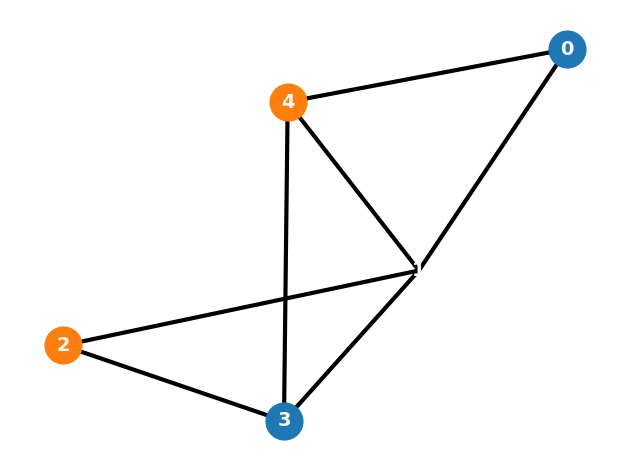

In [25]:
# Visulize the result
graph_coloring_viz(G, coloring)

[click here for solution](BQM_Graph_Coloring_Solutions.ipynb#Task5)

### Task 6

For the Petersen graph displayed below, determine the minimum number of colors needed to properly color the graph.

Hint: Starting with 2 colors, increase the number of colors you use inside a loop until a feasible coloring is found.

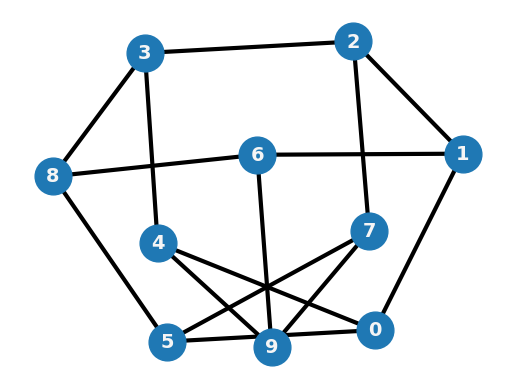

In [26]:
Gp = nx.petersen_graph()
graph_viz(Gp)

{0: 2, 1: 1, 2: 2, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 2, 9: 1}
3  colors are used


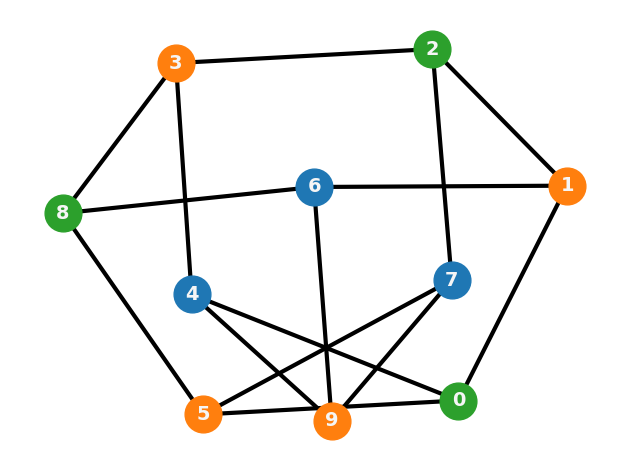

In [33]:

#Your code here
sampler = SimulatedAnnealingSampler()
edges = Gp.edges
N = len(Gp.nodes)
for k in list(range(2, 10)):
    colors = list(range(k))
    bqm = graph_coloring_bqm(colors, edges, N)
    sampleset = sampler.sample(bqm, num_reads=100)
    first_sample = sampleset.first.sample
    if is_sample_feasible(first_sample, colors, edges, N):
        break
coloring = sample_to_coloring(first_sample, colors, N)
print(coloring)
print(k, " colors are used")
graph_coloring_viz(Gp, coloring)

[click here for solution](BQM_Graph_Coloring_Solutions.ipynb#Task6)

# References

1. F. Glover, G. Kochenberger and Y. Du. "Quantum Bridge Analytics I: A Tutorial on Formulating and Using QUBO Models," [arXiv:1811.11538v6](https://arxiv.org/abs/1811.11538v6), 2019.

2. ["Graph Coloring"](https://github.com/dwave-examples/graph-coloring),  D-Wave Systems Examples, accessed December 2021.

3. ["Map Coloring"](https://github.com/dwave-examples/map-coloring),  D-Wave Systems Examples, accessed December 2021.